In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import time

# Check for GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Hyperparams

In [3]:
LR = 1e-3 # learning rate
NUM_ITER = 10000 # number iterations

NZ = 512 # input seed dimension
NGF = 64 # number of filters per layer
NC = 2 # number of channels

# Grab the data

In [4]:
x_labels = torch.load("/scratch/04703/sravula/UTAFSDataNew/FREQ_VALS.pt")
x_raw = torch.load("/scratch/04703/sravula/UTAFSDataNew/X_RAW.pt")

In [5]:
print(len(x_labels))
print(x_labels[0].shape)

print(len(x_raw))
print(x_raw[0].shape)

1406
torch.Size([1000])
1406
torch.Size([1000, 10, 2])


In [6]:
min_arr = [torch.min(t).item() for t in x_raw]
max_arr = [torch.max(t).item() for t in x_raw]

print("MIN VAL: ", np.min(min_arr))
print("MAX VAL: ", np.max(max_arr))

MIN VAL:  -0.9739965796470642
MAX VAL:  0.9999977946281433


## Looks like there's no need to normalize the data further....

In [7]:
sample_idx = 0
chip_idx = 0

labels = x_labels[sample_idx]
x = x_raw[sample_idx][:, chip_idx, :]
x = (x.T).unsqueeze(0)

print(x.shape)
print(labels.shape)

torch.Size([1, 2, 1000])
torch.Size([1000])


In [8]:
def get_inds(problem_type, length, num_kept_samples):
    """Given a number of samples to keep and a problem type, returns indices to keep from a list"""
    if problem_type=="random":
        kept_inds = np.random.choice(length, num_kept_samples, replace=False)
    elif problem_type=="equal":
        kept_inds = np.arange(0, length, (length // num_kept_samples))
    elif problem_type=="forecast":
        kept_inds = np.arange(0, num_kept_samples)
    else:
        raise NotImplementedError("THIS PROBLEM TYPE IS UNSUPPORTED")
    
    missing_inds = np.array([t for t in range(length) if t not in kept_inds])
    
    return np.sort(kept_inds), np.sort(missing_inds)

In [9]:
PROBLEM_TYPE = "random" #[random, equal, forecast]
LENGTH = x.shape[-1]
M = 100

kept_inds, missing_inds = get_inds(PROBLEM_TYPE, LENGTH, M)
M = len(kept_inds)

In [10]:
print(LENGTH)
print(M)
print(len(kept_inds))
print(len(missing_inds))

1000
100
100
900


In [11]:
y = torch.clone(x)[:, :, kept_inds]

print(y.shape)

torch.Size([1, 2, 100])


# Visualize the data and the observations

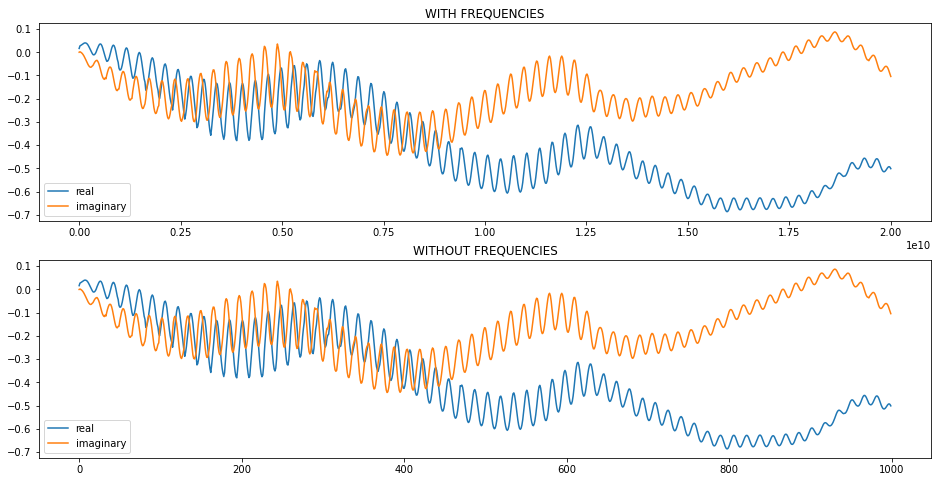

In [12]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

axes[0].plot(labels.flatten(), x[0,0,:].flatten(), label="real")
axes[0].plot(labels.flatten(), x[0,1,:].flatten(), label="imaginary")
axes[0].legend()
axes[0].set_title("WITH FREQUENCIES")

axes[1].plot(x[0,0,:].flatten(), label="real")
axes[1].plot(x[0,1,:].flatten(), label="imaginary")
axes[1].legend()
axes[1].set_title("WITHOUT FREQUENCIES")

plt.show()

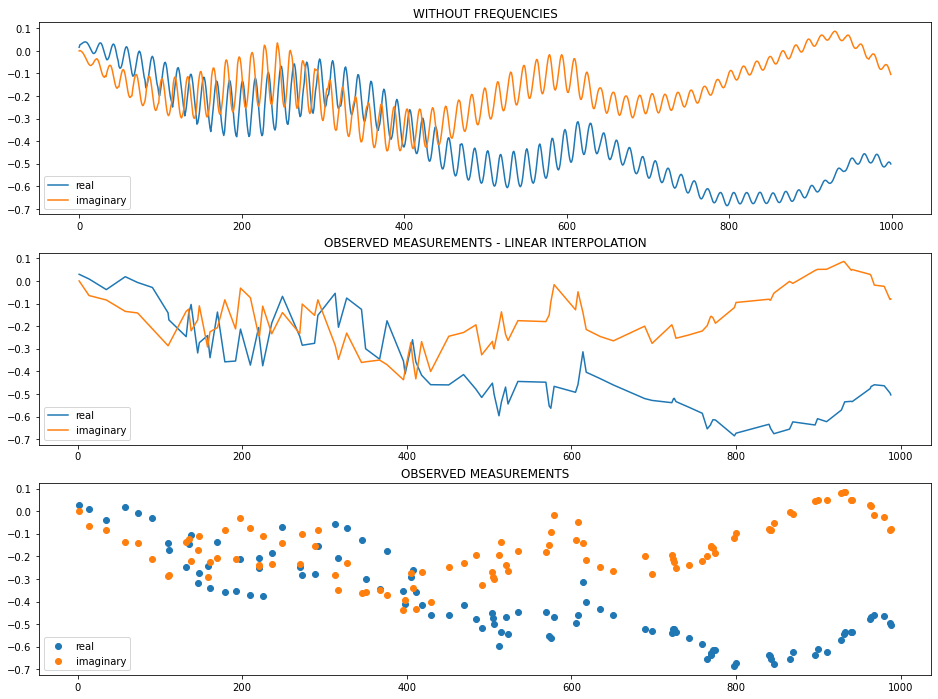

In [13]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

axes[0].plot(x[0,0,:].flatten(), label="real")
axes[0].plot(x[0,1,:].flatten(), label="imaginary")
axes[0].legend()
axes[0].set_title("WITHOUT FREQUENCIES")

axes[1].plot(kept_inds, y[0,0,:].flatten(), label="real")
axes[1].plot(kept_inds, y[0,1,:].flatten(), label="imaginary")
axes[1].legend()
axes[1].set_title("OBSERVED MEASUREMENTS - LINEAR INTERPOLATION")

axes[2].scatter(kept_inds, y[0,0,:].flatten(), label="real")
axes[2].scatter(kept_inds, y[0,1,:].flatten(), label="imaginary")
axes[2].legend()
axes[2].set_title("OBSERVED MEASUREMENTS")

plt.show()

# Set up the network

In [14]:
from models import DCGAN

net = DCGAN(bs=1, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC)
net = net.to(device)

In [15]:
test_out = net.forward_with_z()
print(test_out.shape)

torch.Size([1, 2, 1000])


## Set up and run experiment

In [16]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
test_losses = []

mse_loss = nn.MSELoss()

x = x.to(device)
y = y.to(device)

0


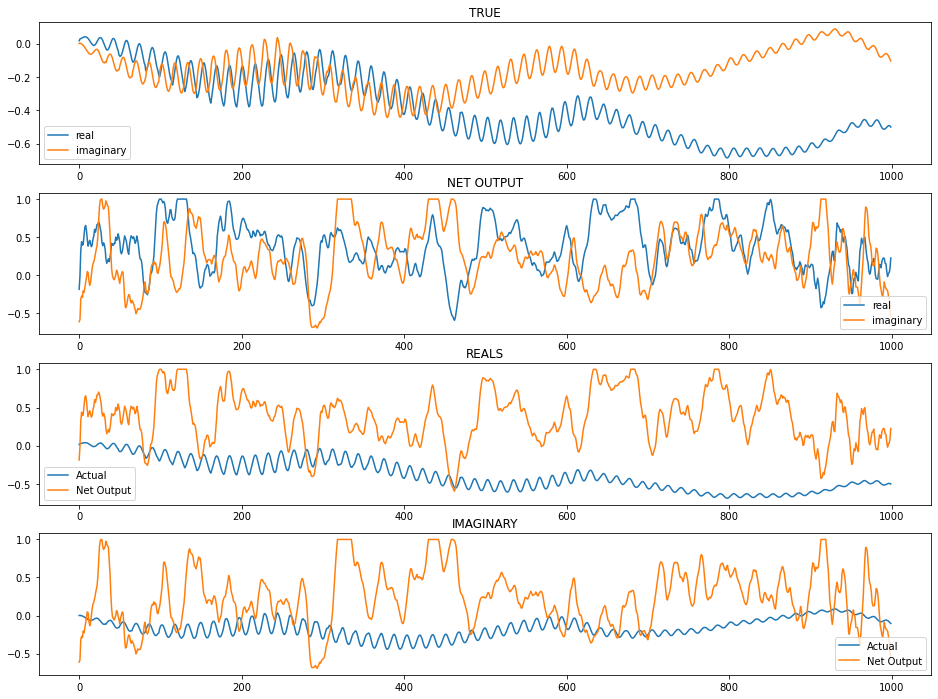

499


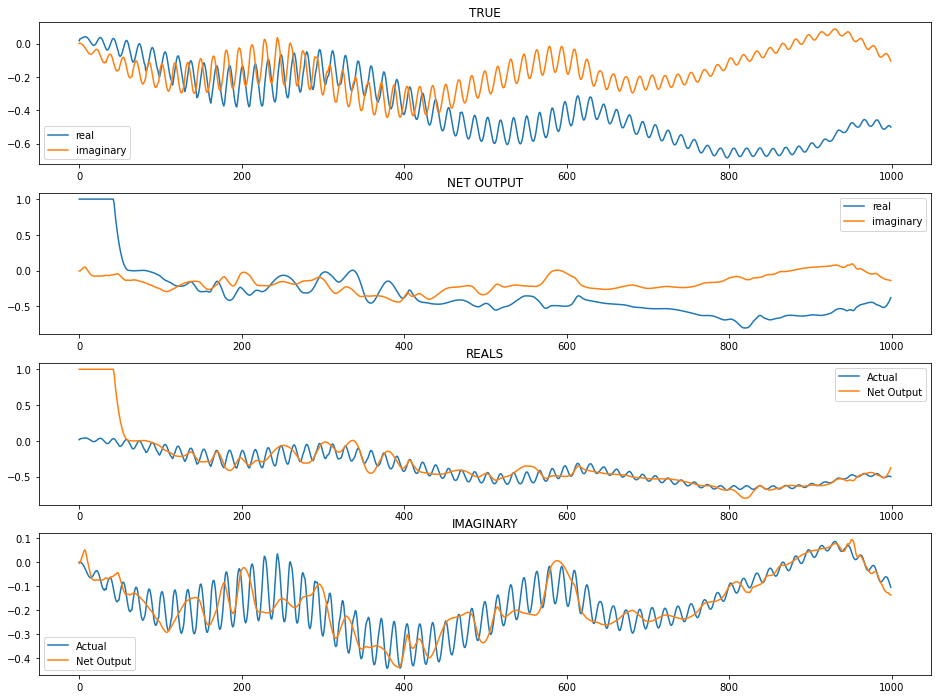

999


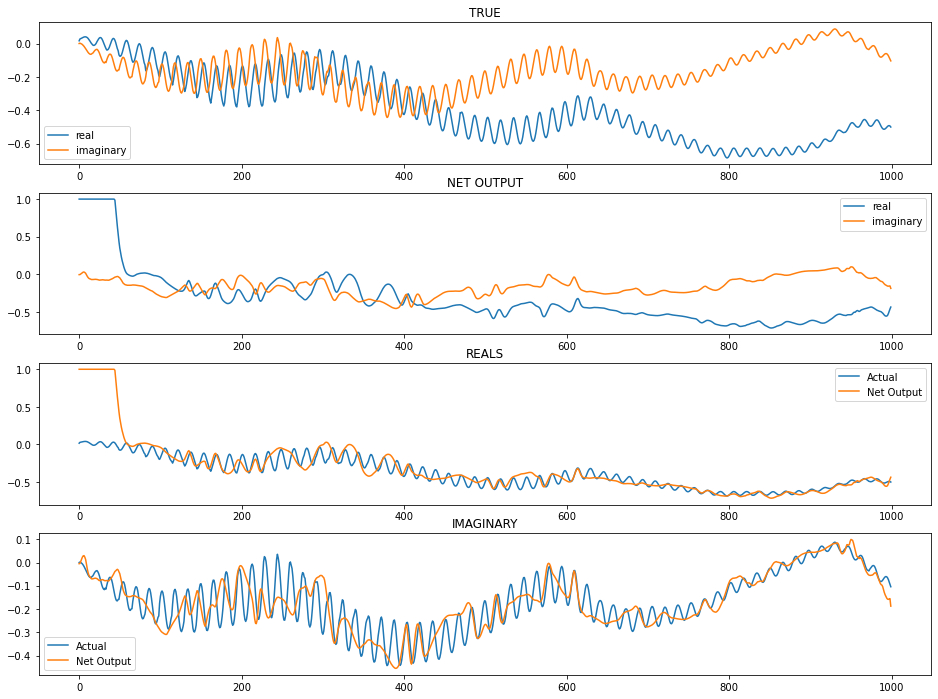

1499


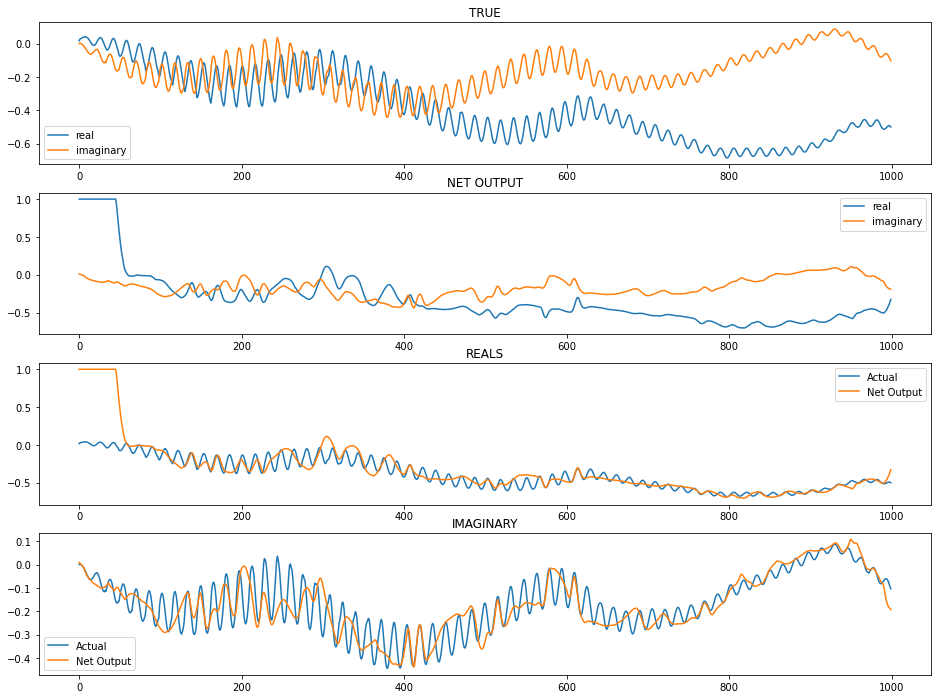

1999


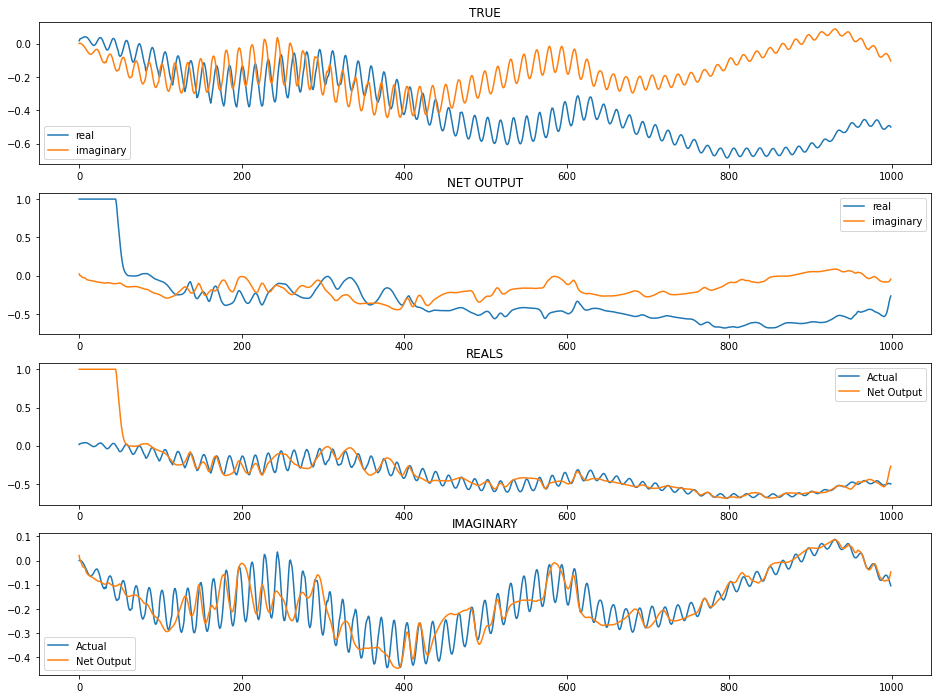

2499


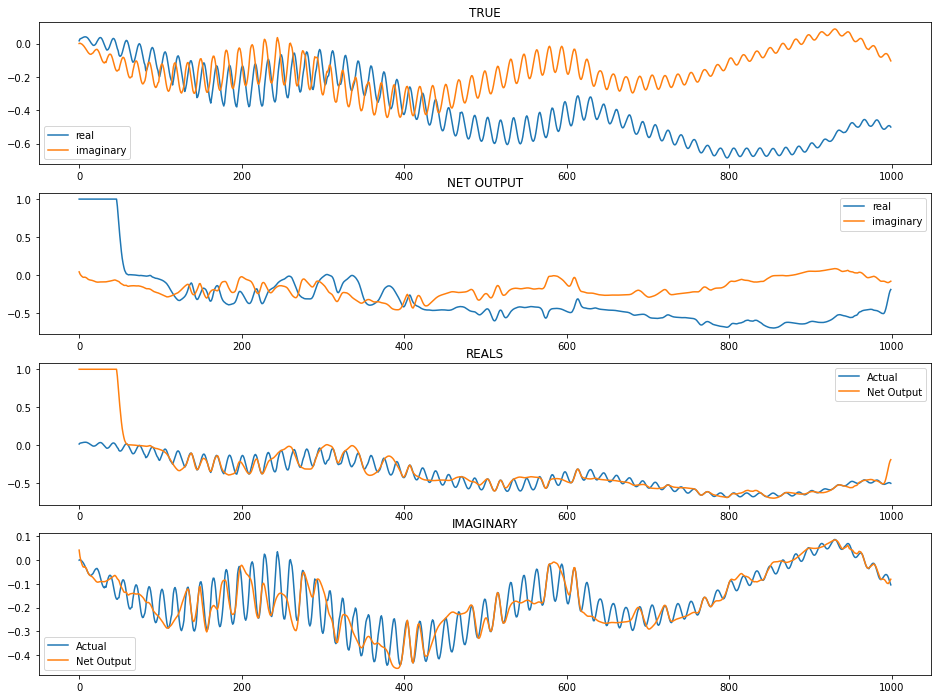

2999


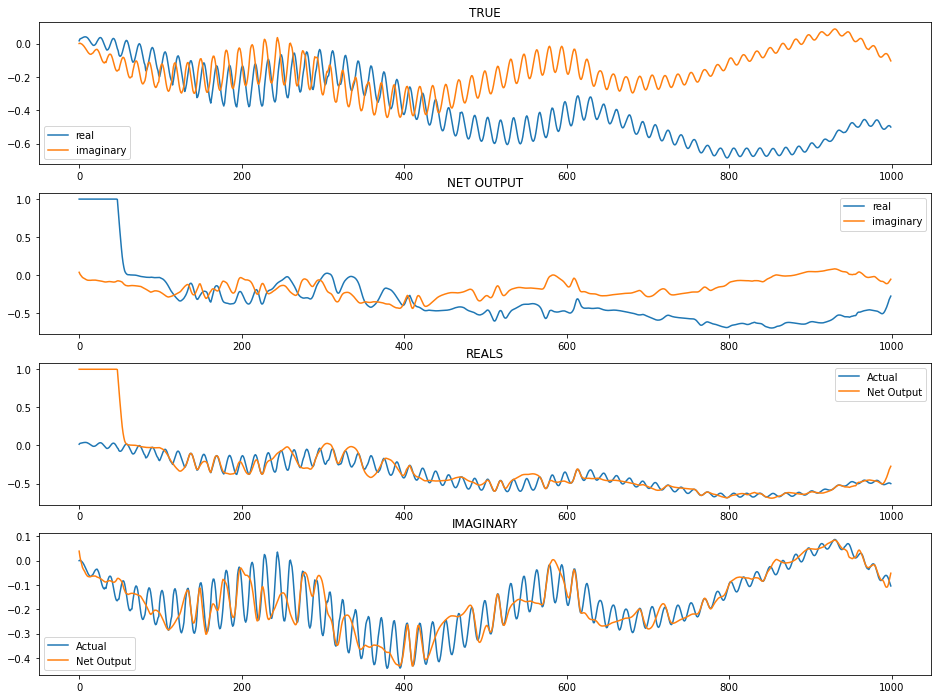

3499


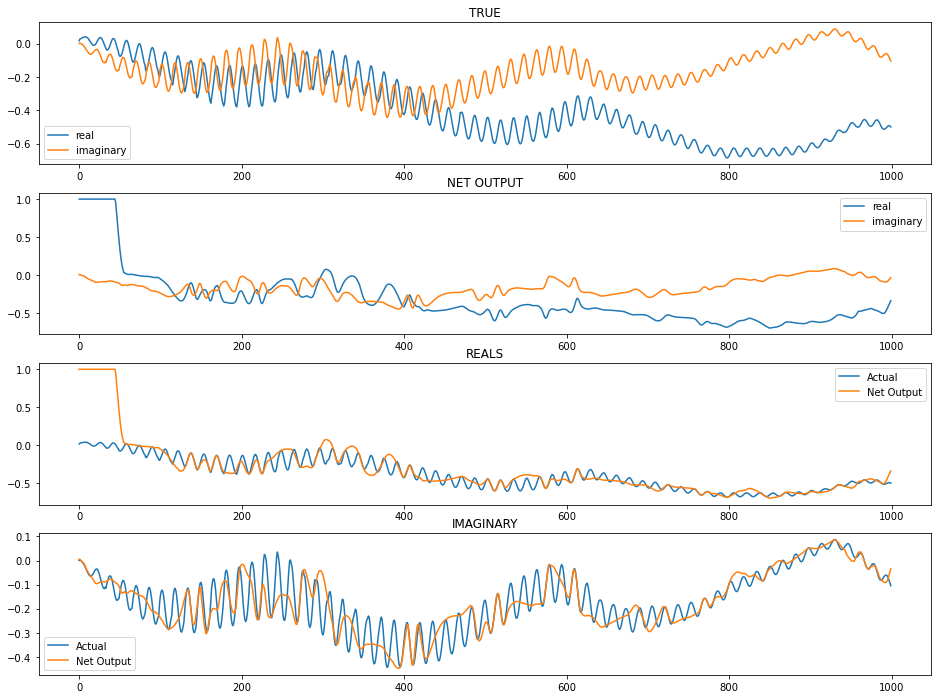

3999


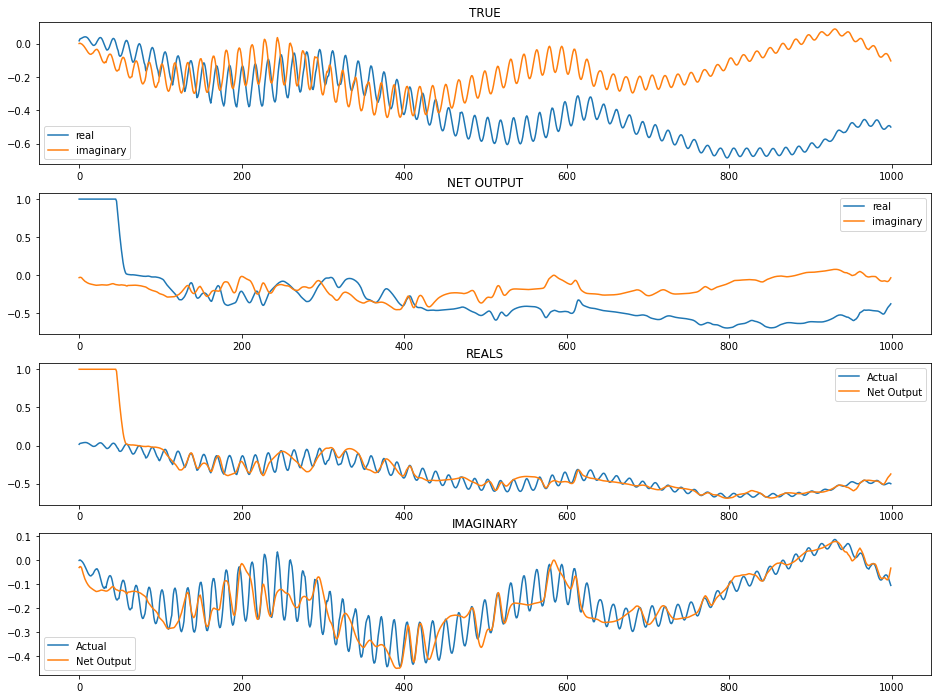

4499


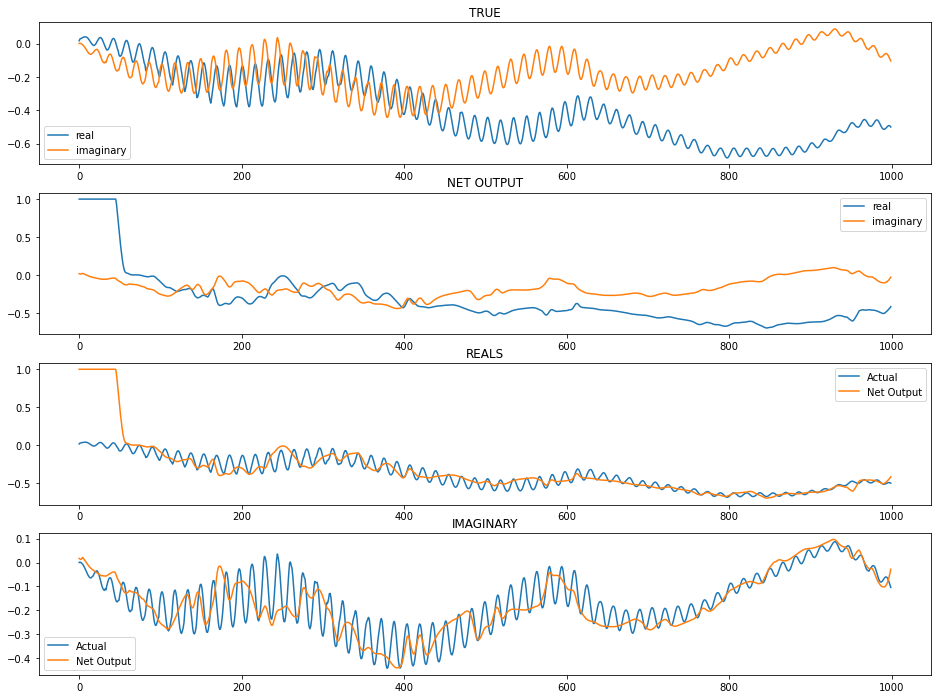

4999


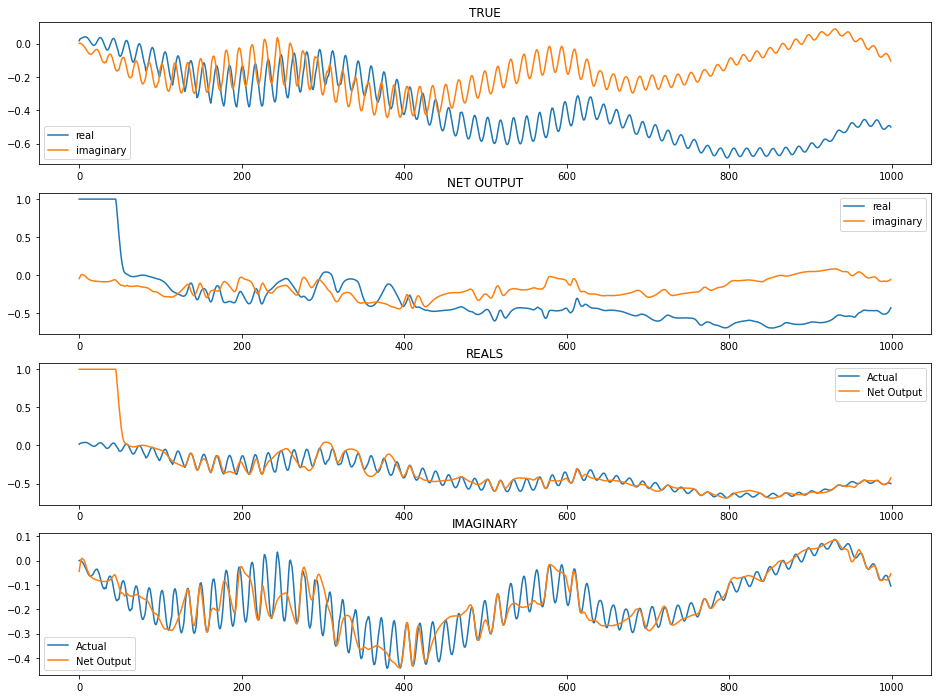

5499


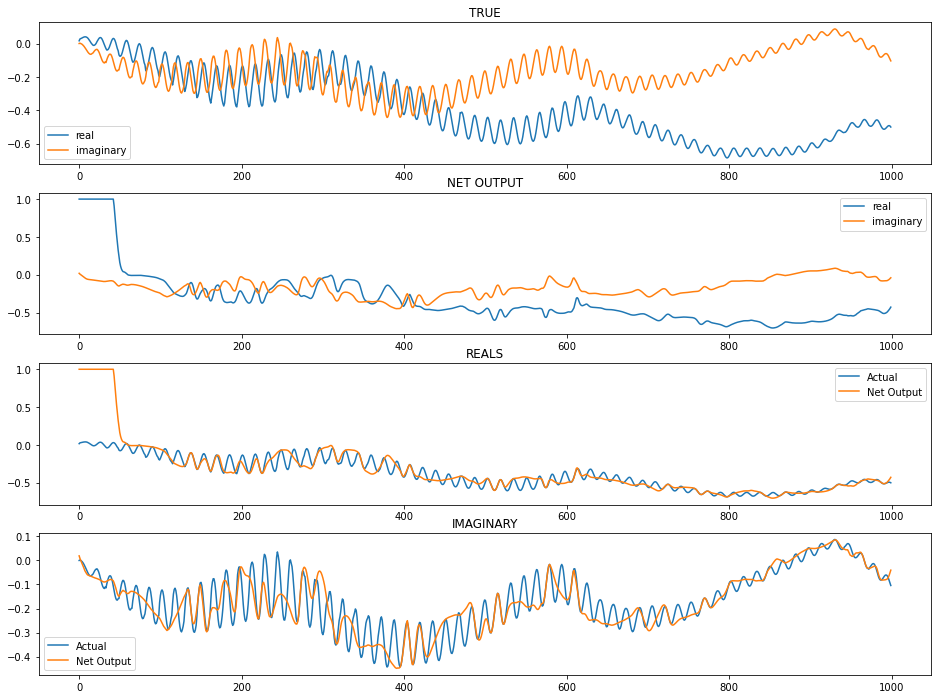

5999


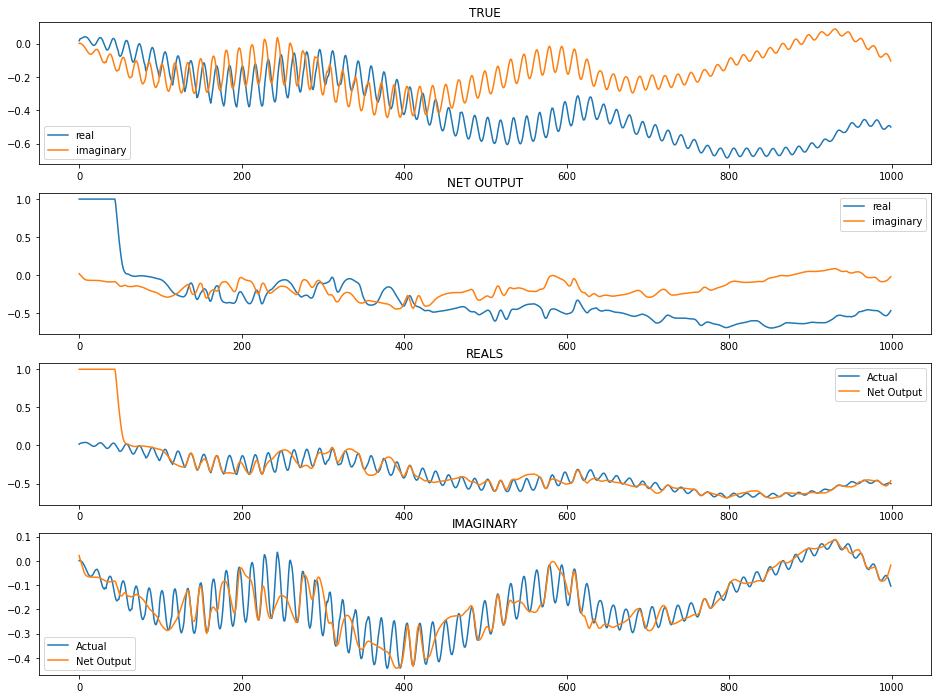

6499


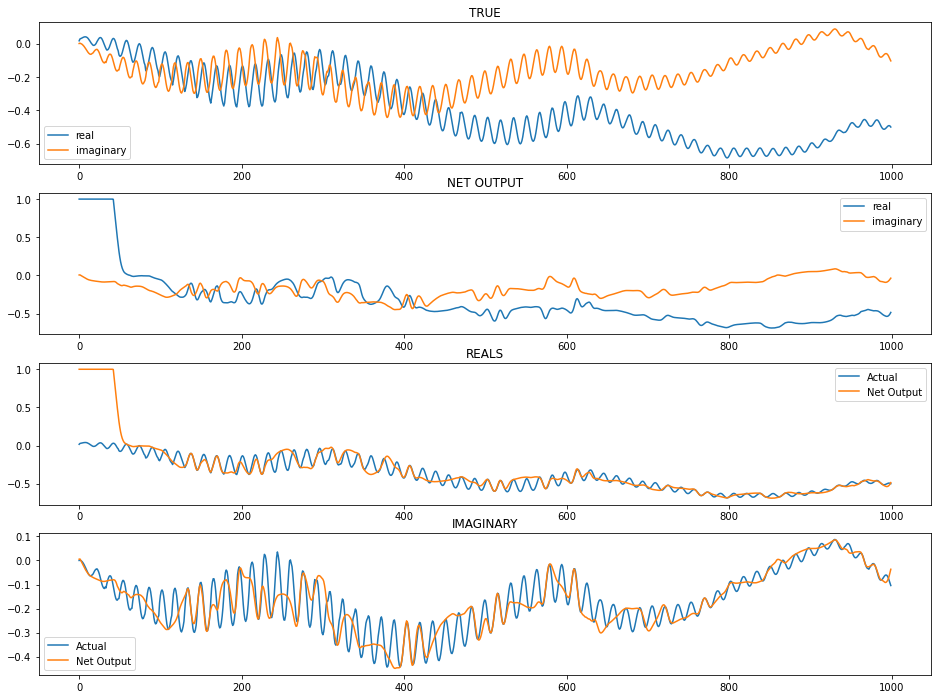

6999


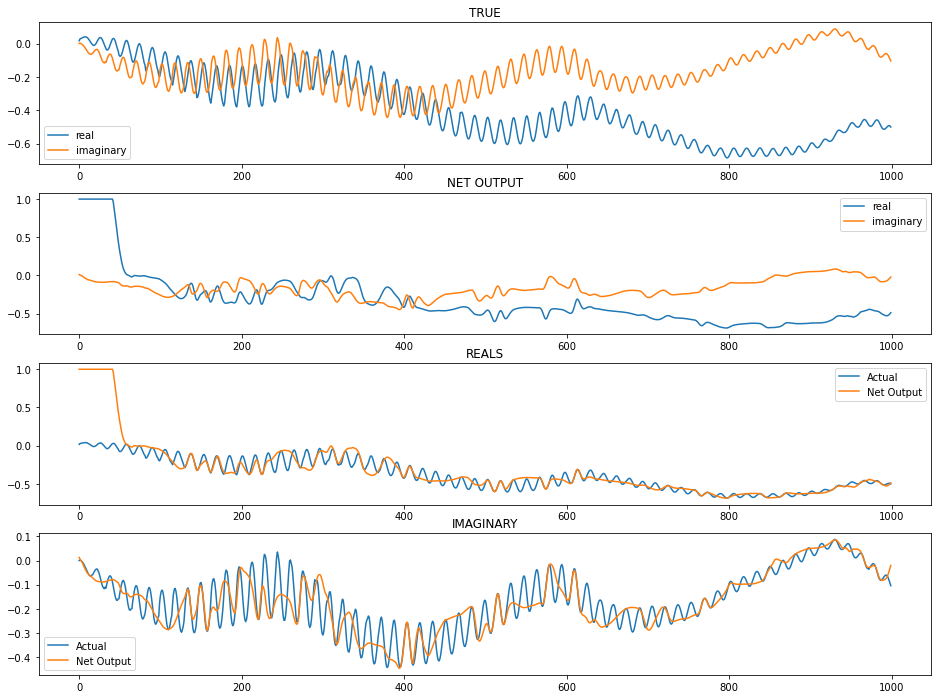

7499


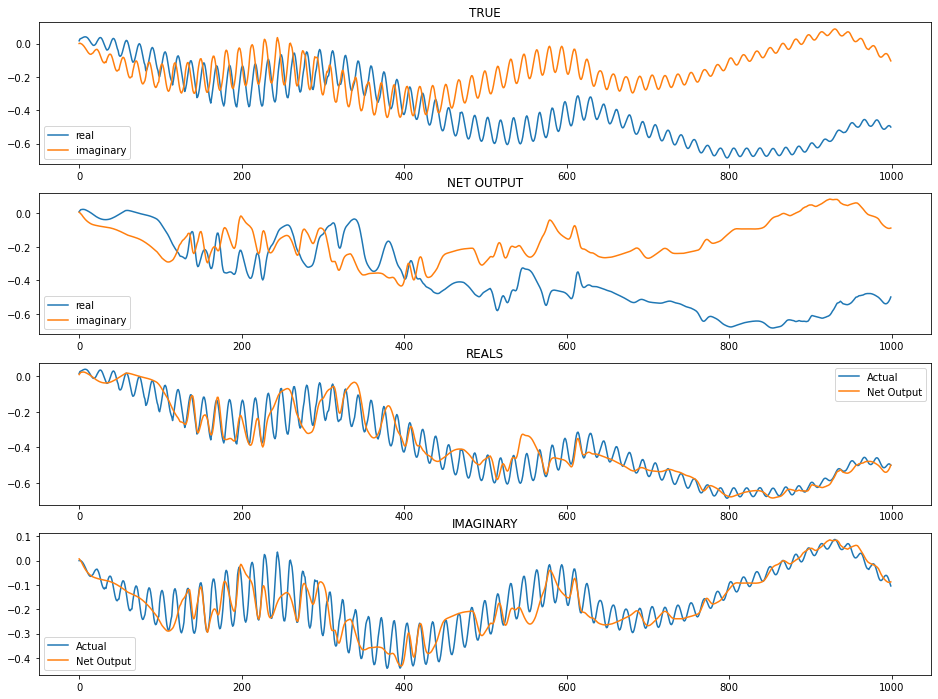

7999


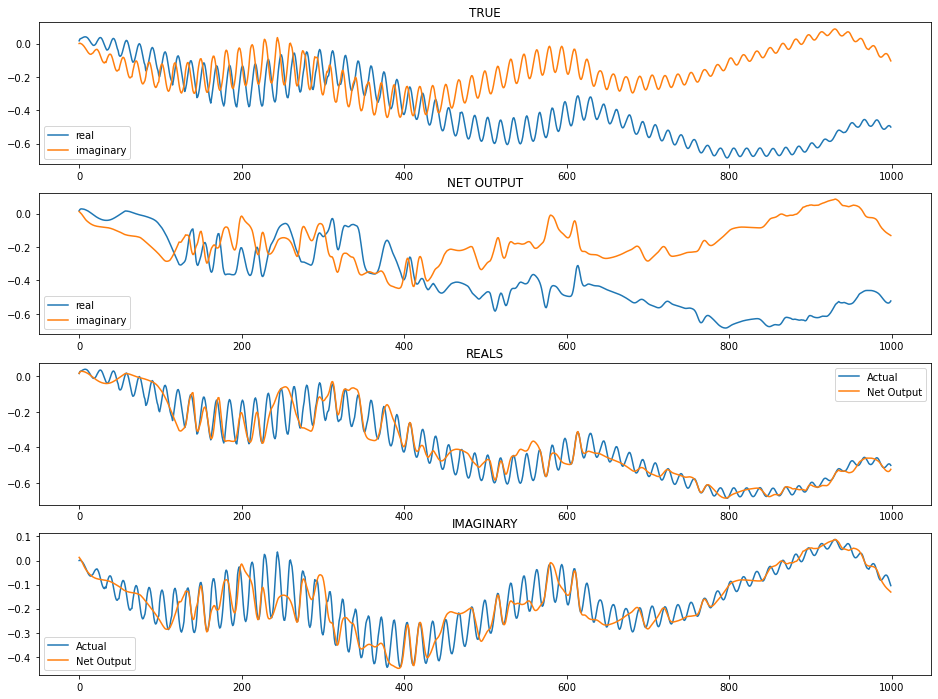

8499


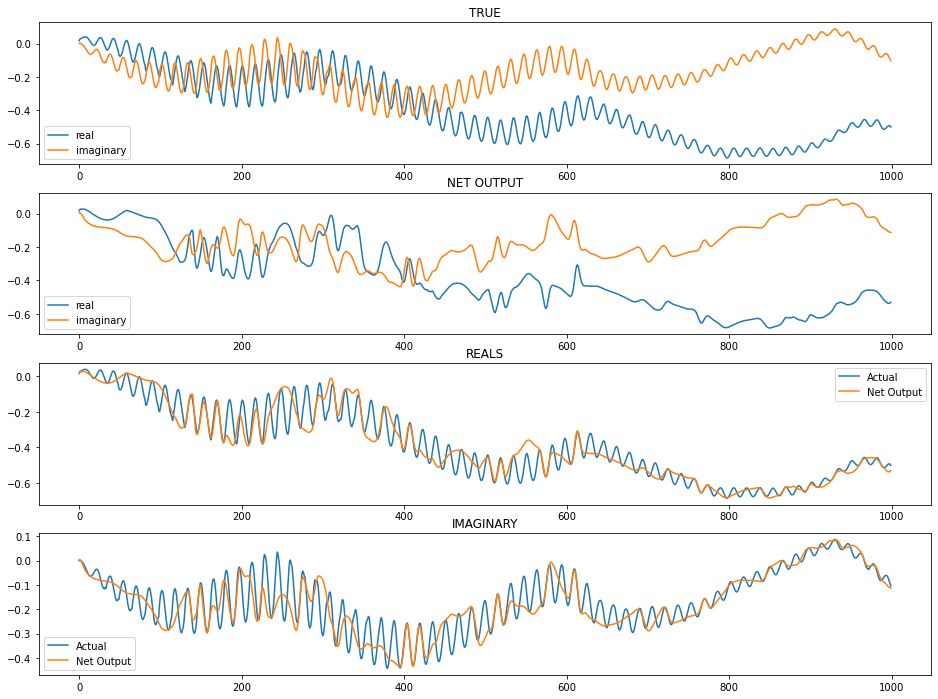

8999


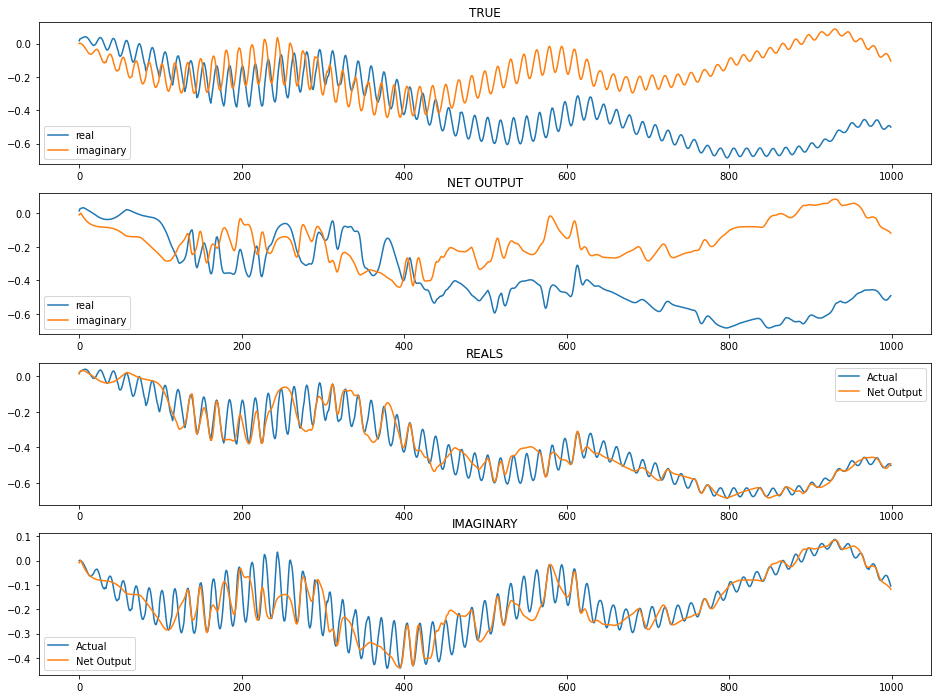

9499


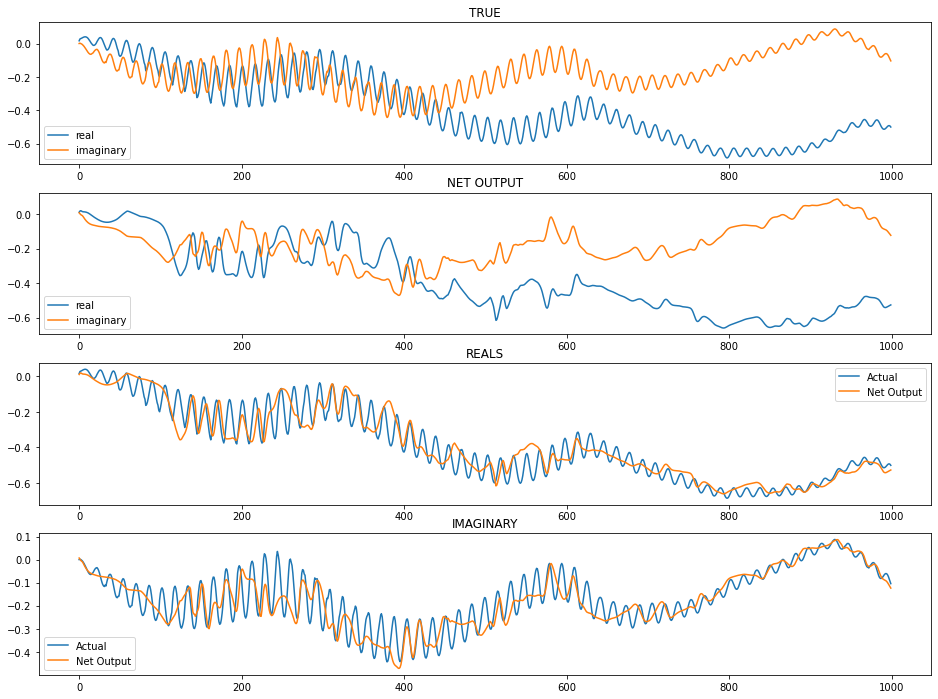

9999


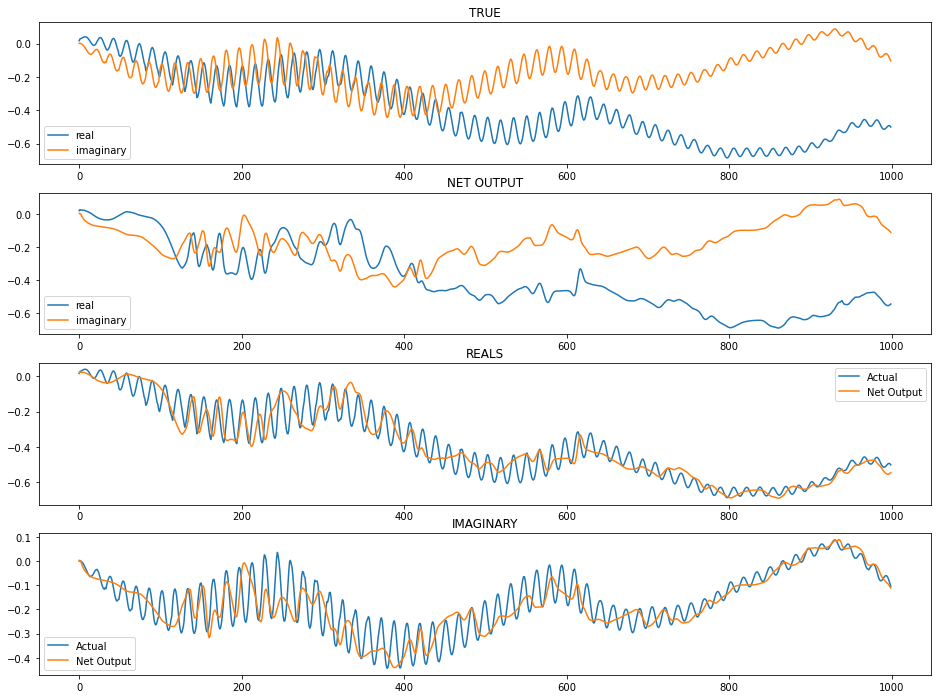

In [17]:
start = time.time()

for i in range(NUM_ITER):
    optim.zero_grad()
    
    out = net.forward_with_z()
    train_loss = mse_loss(out[:, :, kept_inds], y)
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        test_loss = mse_loss(out, x)
    
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if (i+1)%500 == 0 or i == 0:
            print(i)

            fig, axes = plt.subplots(4,1, figsize=(16, 12))
            axes = axes.flatten()

            axes[0].plot(x[0,0,:].flatten().detach().cpu(), label="real")
            axes[0].plot(x[0,1,:].flatten().detach().cpu(), label="imaginary")
            axes[0].legend()
            axes[0].set_title("TRUE")

            axes[1].plot(out[0,0,:].flatten().detach().cpu(), label="real")
            axes[1].plot(out[0,1,:].flatten().detach().cpu(), label="imaginary")
            axes[1].legend()
            axes[1].set_title("NET OUTPUT")

            axes[2].plot(x[0,0,:].flatten().detach().cpu(), label="Actual")
            axes[2].plot(out[0,0,:].flatten().detach().cpu(), label="Net Output")
            axes[2].legend()
            axes[2].set_title("REALS")

            axes[3].plot(x[0,1,:].flatten().detach().cpu(), label="Actual")
            axes[3].plot(out[0,1,:].flatten().detach().cpu(), label="Net Output")
            axes[3].legend()
            axes[3].set_title("IMAGINARY")

            plt.show()

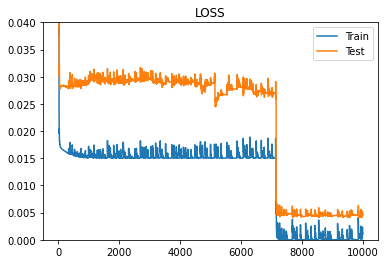

In [20]:
plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.title("LOSS")
plt.ylim(0., 0.04)
plt.legend()
plt.show()